In [17]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn as sns

%matplotlib inline

In [22]:
paths_dict = {
    ("SARS", "MAE"): "../predictions/sars_stats_best_mae.csv",
    ("SARS", "Loss"): "../predictions/sars_stats_best_loss.csv",
    ("MERS", "MAE"): "../predictions/mers_stats_best_mae.csv",
    ("MERS", "Loss"): "../predictions/mers_stats_best_loss.csv",
}

full_stats_df = []
for (target, epoch_choice), stats_fn in paths_dict.items():
    df = pandas.read_csv(stats_fn, index_col=0)
    df["Train Target"] = target
    df["Epoch Choice Method"] = epoch_choice
    full_stats_df.append(df)
full_stats_df = pandas.concat(full_stats_df, axis=0, ignore_index=True)

full_stats_df["stat_type"] = [
    "err" if stat in {"MAE", "RMSE"} else "corr" for stat in full_stats_df["Statistic"]
]

bar_width = 0.8
all_stats = ["MAE", "RMSE", r"Spearman's $\rho$", r"Kendall's $\tau$"]
adj_offset = bar_width / len(all_stats) / 2
stat_adj_dict = dict(zip(all_stats, [-3, -1, 1, 3]))
epoch_choice_pos_dict = {"MAE": 0, "Loss": 1}
full_stats_df["x"] = [
    epoch_choice_pos_dict[epoch_choice] + stat_adj_dict[stat] * adj_offset
    for _, (epoch_choice, stat) in full_stats_df[["Epoch Choice Method", "Statistic"]].iterrows()
]

full_stats_df

,Num Compounds,Statistic,Value,95ci_low,95ci_high,Train Target,Epoch Choice Method,stat_type,x
0,108,MAE,0.454969,0.374229,0.533021,SARS,MAE,err,-0.3
1,108,RMSE,0.622451,0.524550,0.730066,SARS,MAE,err,-0.1
2,108,Spearman's $\rho$,0.746349,0.658820,0.866405,SARS,MAE,corr,0.1
3,108,Kendall's $\tau$,0.569198,0.476974,0.673559,SARS,MAE,corr,0.3
4,108,MAE,0.454969,0.374347,0.532915,SARS,Loss,err,0.7
5,108,RMSE,0.622451,0.522876,0.729947,SARS,Loss,err,0.9
6,108,Spearman's $\rho$,0.746349,0.657799,0.866468,SARS,Loss,corr,1.1
7,108,Kendall's $\tau$,0.569198,0.476615,0.673973,SARS,Loss,corr,1.3
8,84,MAE,0.325124,0.268538,0.379938,MERS,MAE,err,-0.3
9,84,RMSE,0.418188,0.363328,0.476595,MERS,MAE,err,-0.1


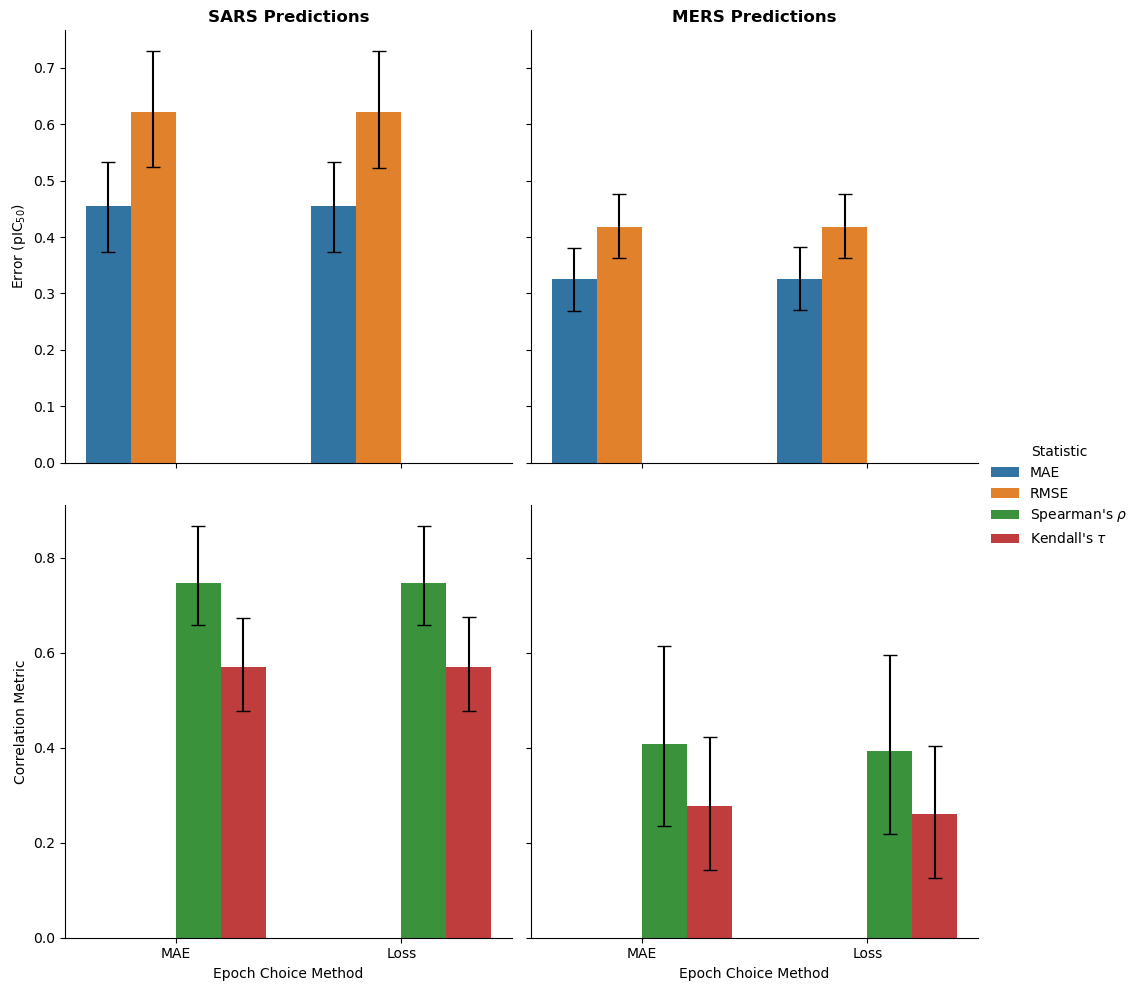

In [24]:
fg = sns.catplot(
    full_stats_df,
    x="Epoch Choice Method",
    order=["MAE", "Loss"],
    y="Value",
    hue="Statistic",
    hue_order=all_stats,
    col="Train Target",
    col_order=["SARS", "MERS"],
    row="stat_type",
    row_order=["err", "corr"],
    kind="bar",
    sharey="row",
)

fg.set_axis_labels("Epoch Choice Method", "")
fg.set_titles(template="")

# Set column titles
fg.axes.flatten()[0].set_title("SARS Predictions", fontdict={"fontweight": "bold"})
fg.axes.flatten()[1].set_title("MERS Predictions", fontdict={"fontweight": "bold"})

fg.axes[0, 0].set_ylabel("Error (pIC$_\mathrm{50}$)")
fg.axes[1, 0].set_ylabel("Correlation Metric")

# Add in errorbars
color_palette = dict(zip(all_stats, sns.color_palette()))
for (stat_type, target), ax in fg.axes_dict.items():
    base_idx = (
        (full_stats_df["stat_type"] == stat_type)
        & (full_stats_df["Train Target"] == target)
    )
    for epoch_choice, stat in product(["MAE", "Loss"], all_stats):
        idx = (
            base_idx
            & (full_stats_df["Statistic"] == stat)
            & (full_stats_df["Epoch Choice Method"] == epoch_choice)
        )
        g = full_stats_df.loc[idx, :]
        # display(g)
        ax.errorbar(
            x=g["x"].values,
            y=g["Value"].values,
            yerr=np.abs(
                g[["95ci_low", "95ci_high"]].values.transpose()
                - g["Value"].values.transpose()
            ),
            fmt="none",
            ecolor="black",
            # ecolor=color_palette[loss],
            capsize=5,
            # alpha=0.5,
        )
    # fg.refline(x=x, ls="--", c="black")